In [1]:
#!pip install ib_insync
#!pip install bs4
from ib_insync import *
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
import quantstats as qs

from utils import *

In [2]:
util.startLoop()
ib = IB()
ib.connect('127.0.0.1', 7497, clientId=19)

<IB connected to 127.0.0.1:7497 clientId=19>

In [3]:
ib.run()

In [4]:
def extract_info(accounts, tag):
    for acc in accounts:
        if tag == acc.tag:
            return acc.value
    return None

In [5]:
account = ib.accountSummary()
print("Net worth:", extract_info(account, "NetLiquidation"))
print("Cash:", extract_info(account, "TotalCashValue"))

Net worth: 1048742.57
Cash: 1044088.65


In [78]:
stock = Stock('NVDA', 'SMART', 'USD', primaryExchange='NASDAQ')
bars = ib.reqHistoricalData(stock, endDateTime = '', durationStr = '1 M', barSizeSetting = '3 mins', whatToShow = 'ADJUSTED_LAST', useRTH = True, formatDate = 2)

In [79]:
print(stock)

Stock(symbol='NVDA', exchange='SMART', primaryExchange='NASDAQ', currency='USD')


In [80]:
ib.qualifyContracts(stock)

[Stock(conId=4815747, symbol='NVDA', exchange='SMART', primaryExchange='NASDAQ', currency='USD', localSymbol='NVDA', tradingClass='NMS')]

In [81]:
dfBars = util.df(bars)
# dfBars = dfBars.set_index('date')
dfBars

date     open     high      low    close    volume  \
0    2024-05-01 13:30:00+00:00   851.65   855.60   849.95   853.95  684913.0   
1    2024-05-01 13:33:00+00:00   853.58   855.00   841.46   846.41  609517.0   
2    2024-05-01 13:36:00+00:00   846.30   849.50   844.00   848.18  427608.0   
3    2024-05-01 13:39:00+00:00   848.22   852.78   847.22   851.47  384552.0   
4    2024-05-01 13:42:00+00:00   851.68   855.21   851.25   852.20  483490.0   
...                        ...      ...      ...      ...      ...       ...   
2620 2024-05-30 14:30:00+00:00  1142.15  1144.54  1140.30  1140.32   35467.0   
2621 2024-05-30 14:33:00+00:00  1140.51  1140.51  1130.02  1132.38  106341.0   
2622 2024-05-30 14:36:00+00:00  1133.60  1134.60  1127.50  1130.03   64205.0   
2623 2024-05-30 14:39:00+00:00  1129.00  1133.10  1128.00  1133.10   41280.0   
2624 2024-05-30 14:42:00+00:00  1132.96  1136.48  1132.70  1136.35   40629.0   

       average  barCount  
0      852.485      2557  
1      846.327      3055  
2      847.236      2088  
3      850.044      1948  
4      853.702      2381  
...        ...       ...  
2620  1142.143       255  
2621  1135.688       615  
2622  1131.006       395  
2623  1130.418       233  
2624  1134.213       270  

[2625 rows x 8 columns]

In [82]:
import typing
import pandas as pd
import numpy as np
import numpy.typing as npt
from utils import load_financial_data
from markov import *
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.optim import AdamW
from models import *
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

In [83]:
from utils import load_financial_data, plot_ts, plot_multi_ts

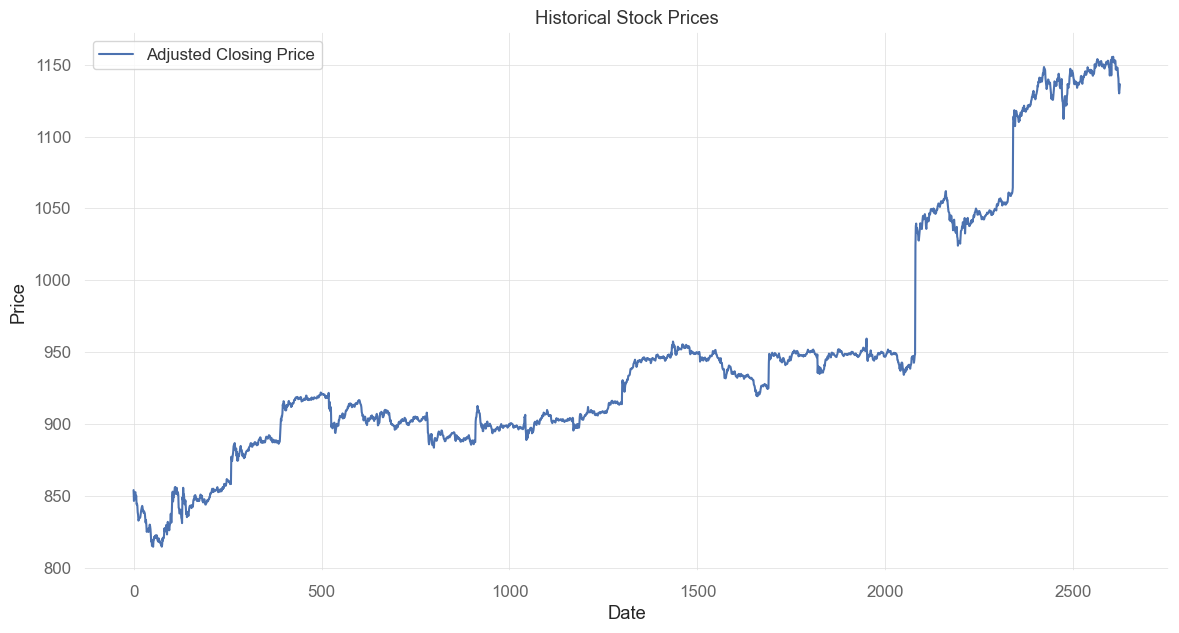

In [84]:
plot_ts(
    data=dfBars["close"], 
    title=f"Historical Stock Prices",
    label_ts="Adjusted Closing Price",
    x_label="Date",
    y_label="Price",
)

In [85]:
security_data = dfBars

In [86]:
from ml import *

In [87]:
markovian_strategy = MLStrategy(
        price=security_data[:-200]["close"],
        valid_data=security_data[-200:]["close"],
        test_data=security_data[-200:]["close"],
        threshold_to_buy=8,
        threshold_to_sell=8,
        lookback=20,
        forward=3,
    )

In [88]:
markovian_strategy.train(
    epochs=50,
    lr=1e-3,
)

100%|██████████| 50/50 [00:14<00:00,  3.53it/s]


In [89]:
markovian_performance = markovian_strategy.backtest(
    initial_cash=2e3,
    num_share_per_trade=1,
    limit_borrow=0,
    limit_num_shorts=0,
    allin=False,
    halfin=False,
)
markovian_performance

  0%|          | 0/181 [00:00<?, ?it/s]

100%|██████████| 181/181 [00:00<00:00, 729.47it/s]


price  daily_return  signals     cash  positions   wealth
2425  1146.09      1.000000        0  2000.00       0.00  2000.00
2426  1140.56     -0.004825        0  2000.00       0.00  2000.00
2427  1138.22     -0.002052        0  2000.00       0.00  2000.00
2428  1136.04     -0.001915        0  2000.00       0.00  2000.00
2429  1133.04     -0.002641        0  2000.00       0.00  2000.00
...       ...           ...      ...      ...        ...      ...
2620  1140.32     -0.001908        0   864.22    1140.32  2004.54
2621  1132.38     -0.006963        0   864.22    1132.38  1996.60
2622  1130.03     -0.002075        0   864.22    1130.03  1994.25
2623  1133.10      0.002717        0   864.22    1133.10  1997.32
2624  1136.35      0.002868        0   864.22    1136.35  2000.57

[200 rows x 6 columns]

In [90]:
import matplotlib.pyplot as plt

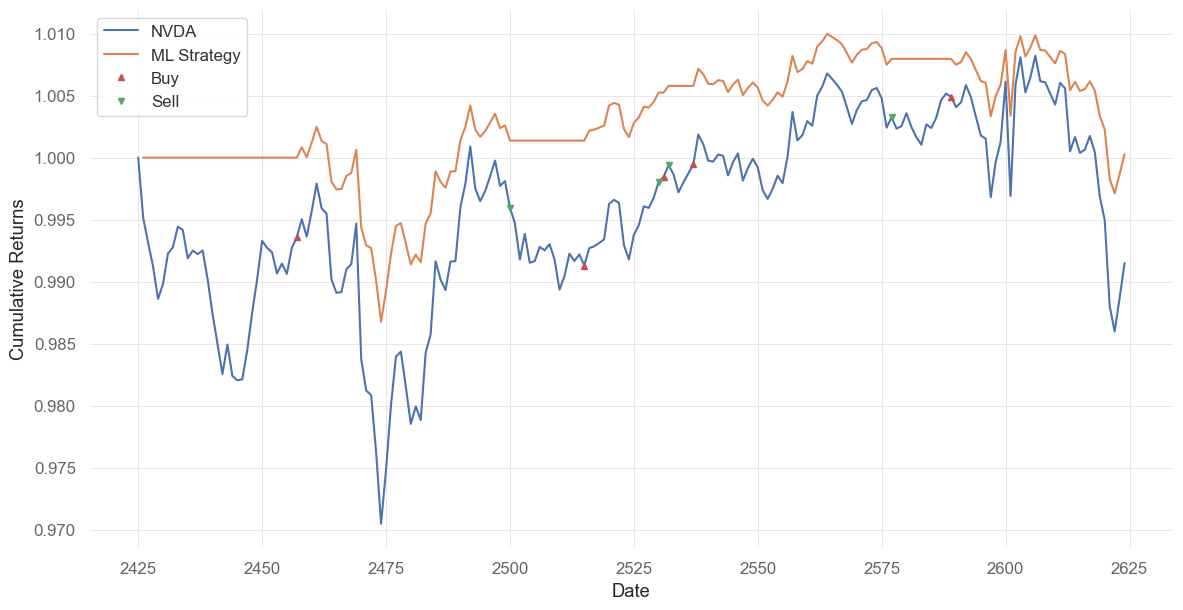

In [91]:
price = security_data[-200:]["close"]
# price = security_data["Adj Close"]

# Plot both cumulative returns on the same chart 
plt.figure(figsize=(14, 7)) 
plt.plot(price.index, price / price.iloc[0], label="NVDA") 
plt.plot(markovian_performance.index, (1 + markovian_performance.wealth.pct_change()).cumprod(), label='ML Strategy')

plt.plot(markovian_performance.loc[markovian_performance.signals == 1.0].index, (price / price.iloc[0])[markovian_performance.signals == 1.0], '^', markersize=5, color='r', label="Buy")
plt.plot(markovian_performance.loc[markovian_performance.signals == -1.0].index, (price / price.iloc[0])[markovian_performance.signals == -1.0], 'v', markersize=5, color='g', label="Sell")


plt.xlabel('Date') 
plt.ylabel('Cumulative Returns') 
plt.legend() 
plt.show()

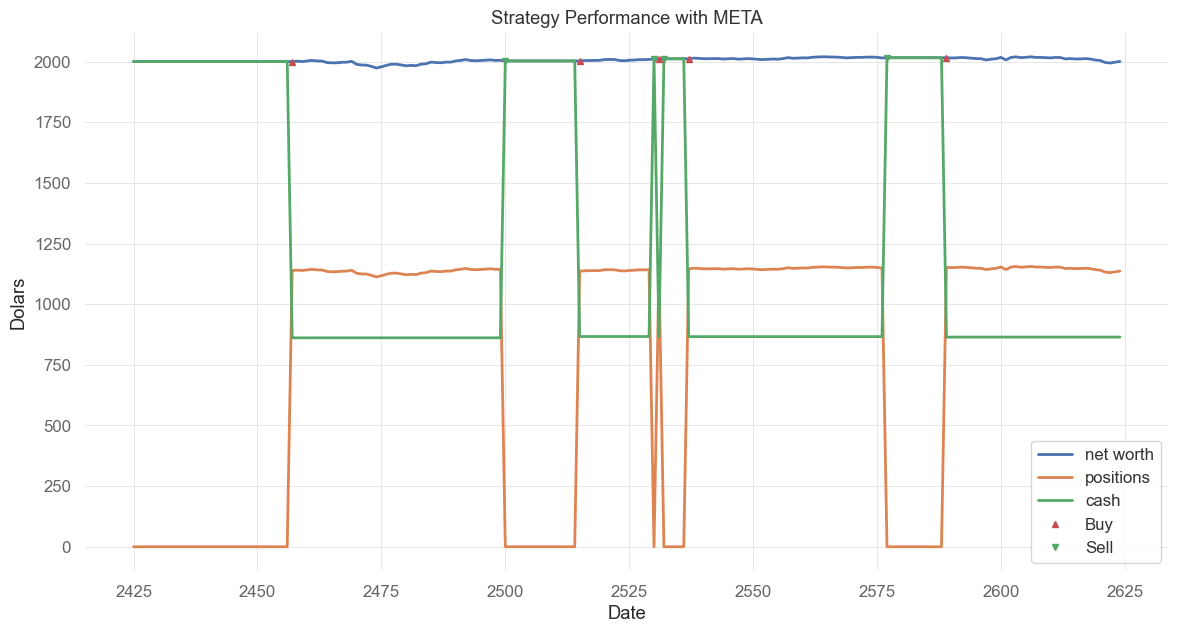

In [92]:
buy_and_hold = price

fig = plt.figure(figsize=(14, 7))
ax1 = fig.add_subplot(111, ylabel = 'Price in USD')
markovian_performance.wealth.plot(ax=ax1, lw=2., label="net worth")
markovian_performance.positions.plot(ax=ax1, lw=2., label="positions")
markovian_performance.cash.plot(ax=ax1, lw=2., label="cash")

ax1.plot(markovian_performance.loc[markovian_performance.signals == 1.0].index, markovian_performance.wealth[markovian_performance.signals == 1.0], '^', markersize=5, color='r', label="Buy")
ax1.plot(markovian_performance.loc[markovian_performance.signals == -1.0].index, markovian_performance.wealth[markovian_performance.signals == -1.0], 'v', markersize=5, color='g', label="Sell")

plt.xlabel("Date")
plt.ylabel("Dolars")
plt.title(f"Strategy Performance with META")
plt.legend()
plt.show()

In [21]:
ib.sleep(0)
# Use this code to update the transmitted information

True

In [22]:
import warnings
warnings.filterwarnings("ignore")

In [23]:
import datetime
datetime.datetime.now().time() >= datetime.time(4, 50)
datetime.datetime.now().time() >= datetime.time(0, 43)

True

In [24]:
markovian_performance = markovian_strategy.deploy(
    ib=ib,
    ticker="NVDA",
    initial_cash=1e3,
    num_share_per_trade=1,
    limit_borrow=0,
    limit_num_shorts=0,
    freq=5,
    allin=False,
    halfin=False,
)
markovian_performance

KeyboardInterrupt: 

In [ ]:
markovian_performance.to_csv("result-META.csv")